In [39]:
!pip install langchain langchain_community langgraph langsmith langchain_groq

In [40]:
from typing import Annotated
from typing_extensions import TypedDict

In [41]:
#working with tools
from langchain_community.utilities import ArxivAPIWrapper
from langchain_community.tools import ArxivQueryRun

In [42]:
!pip install arxiv

In [43]:
#arxiv tool
arxiv_wrapper=ArxivAPIWrapper(top_k_result=1,doc_content_chars_max=300)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_wrapper)

In [44]:
arxiv_tool.invoke("Attention is all you need")

'Published: 2021-05-06\nTitle: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet\nAuthors: Luke Melas-Kyriazi\nSummary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their mult'

In [45]:
tools=[arxiv_tool]

In [46]:
#langgraph application
from langgraph.graph.message import add_messages
class State(TypedDict):
  messages:Annotated[list,add_messages]

In [47]:
from langgraph.graph import StateGraph,START,END

In [48]:
graph_builder=StateGraph(State)

In [49]:
from langchain_groq import ChatGroq
from google.colab import userdata
groq_api_key=userdata.get('GROQ_API')
llm=ChatGroq(groq_api_key=groq_api_key,model="llama-3.1-8b-instant")

In [50]:
llm_with_tools=llm.bind_tools(tools=tools)

In [51]:
from langchain_core.messages import SystemMessage
SYSTEM_MSG = SystemMessage(
    content=(
        "You are a helpful AI assistant. "
        "Use the ArXiv tool ONLY when the user asks about research papers, "
        "academic work, or scientific literature. "
        "Otherwise, answer directly."
    )
)


In [52]:
def chatbot(state: State):
    response = llm_with_tools.invoke(
        [SYSTEM_MSG] + state["messages"]
    )
    return {"messages": [response]}


In [53]:
from langgraph.prebuilt import ToolNode,tools_condition

In [54]:
graph_builder = StateGraph(State)

# nodes
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools))

# edges
graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)

# compile
graph = graph_builder.compile()


In [55]:
graph=graph_builder.compile()

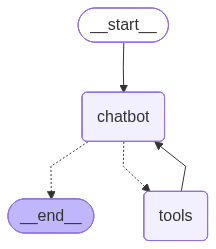

In [56]:
graph

In [57]:
user_input = "give research papers related to attention mechanism"

events = graph.stream(
    {"messages": [("user", user_input)]},
    stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()


================================ Human Message =================================

give research papers related to attention mechanism
================================== Ai Message ==================================
Tool Calls:
  arxiv (h4g5ym2sq)
 Call ID: h4g5ym2sq
  Args:
    query: attention mechanism in deep learning research papers
================================= Tool Message =================================
Name: arxiv

Published: 2023-02-08
Title: The Modern Mathematics of Deep Learning
Authors: Julius Berner, Philipp Grohs, Gitta Kutyniok, Philipp Petersen
Summary: We describe the new field of mathematical analysis of deep learning. This field emerged around a list of research questions that were not answered wit
================================== Ai Message ==================================
Tool Calls:
  arxiv (54gp8qyyp)
 Call ID: 54gp8qyyp
  Args:
    query: attention mechanism computer science research papers 2017
================================= Tool Message =========